# 02 - Data from the web

In [667]:
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import json
from io import StringIO

import time

In [668]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool, Title
from bokeh.models.tickers import FixedTicker
from bokeh.models.formatters import FuncTickFormatter
output_notebook()

Loading BokehJS ...

## Table of Contents
<div class="lev1"><a href="#Overview"><span class="toc-item-num">0&nbsp;&nbsp;</span>Overview</a></div>
<div class="lev1"><a href="#Useful-Functions"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Useful functions</a></div>
<div class="lev1"><a href="#QS-World-University-Ranking"><span class="toc-item-num">1&nbsp;&nbsp;</span>QS World University Ranking</a></div>
 <div class="lev2"><a href="#Ratio-of-faculty-members-and-international-students-(worldwide)">
 <span class="toc-item-num">1.1&nbsp;&nbsp;</span>Ratio of faculty members and international students (worldwide)</a></div>
 <div class="lev2"><a href="#Ratio-of-faculty-members-and-international-students-(by-region)">
 <span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ratio of faculty members and international students (by region)</a></div> 
 <div class="lev2"><a href="#Ratio-of-faculty-members-and-international-students-(by-country)">
 <span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ratio of faculty members and international students (by country)</a></div>
 
 <div class="lev1"><a href="#2---Times-Higher-Education-University-Ranking">
 <span class="toc-item-num">2&nbsp;&nbsp;</span>Times Higher Education University Ranking</a></div>
 <div class="lev2"><a href="#2.1-Ratio-of-faculty-members-and-international-students-(worldwide)">
 <span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ratio of faculty members and international students (worldwide)</a></div>
 <div class="lev2"><a href="#2.2-Ratio-of-faculty-members-and-international-students-(by-region)">
 <span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ratio of faculty members and international students (by region)</a></div>
 <div class="lev2"><a href="#2.3-Ratio-of-faculty-members-and-international-students-(by-country)">
 <span class="toc-item-num">2.3&nbsp;&nbsp;</span>Ratio of faculty members and international students (by country)</a></div>
 
 <div class="lev1"><a href="#3---Merging-the-QS-and-the-THE-rankings">
 <span class="toc-item-num">3&nbsp;&nbsp;</span>Merging the QS and the THE rankings</a></div>
 
 <div class="lev1"><a href="#4---Correlations">
 <span class="toc-item-num">4&nbsp;&nbsp;</span>Correlations</a></div>
 
 <div class="lev1"><a href="#5---Best University">
 <span class="toc-item-num">5&nbsp;&nbsp;</span>Best University</a></div>

## Overview
In this homework, we want to extract interesting information from two websites\ that maintain a global ranking of worldwide universities.
<center><br>
$\rightarrow$ [www.topuniversities.com](www.topuniversities.com) $\leftarrow$<br>
$\rightarrow$[www.timeshighereducation.com](www.timeshighereducation.com)$\leftarrow$
</center>

|Data of interest |     |  |  |  | |
|:----|:----|:--------|:-------|:---|:---|
| Name | Rank | Country | Region |  # of International staff  |       Total # of staff | Total # of students |

<div class="alert alert-block alert-info"> Note : We will use only the 200 top-ranking universities </div>


To this purpose, we first need to extract the data, then parse and store it in a *pandas DataFrame*. 

We can then compute :
+ The ratio between faculty members and students $ = R_{S} $
+ The international students ratio $ = R_{I}$

either worldwide, by region or by country.

$$ R_{S} = \frac{\#\ Students}{\#\ Staff}$$

$$ R_{I} =  \frac{\#\ Students_{international}}{\#\ Students}$$

And sort the universities with respect to these ratios. For each case, we make several interesting plots.
***

In a third part, we merge the DataFrames from both sources, keeping the original ranking. We can then compute the correlation between any pair of variables in this new dataset. 

***
Finally, we use our own approach to compute the best university ranking.

***




### Useful Functions

In [669]:
#use async for more efficiency
import asyncio
async def main():
    loop = asyncio.get_event_loop()
    futures = [
        loop.run_in_executor(
            None, 
            setnumber, 
            index,
            url
        )
        for index,url in zip(dataQS.index, dataQS["url"])
    ]
    
    for response in await asyncio.gather(*futures):
        for tuble in response : 
            dataQS.set_value(*tuble)

#### Plotting functions

In [670]:
def plot_top_n(dataframe, column, top, ascending, title, xlabel, ylabel, url):
    ax = dataframe.sort_values(column, ascending=ascending).head(top) \
               .plot(y=column, 
                     x='title', 
                     kind='bar', 
                     grid=True, 
                     figsize=(20, 6), 
                     title=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.gca().set_position((0.0, 0.9, 0.8, 0.8))
    plt.figtext(0.0, 0.0, "Data from: " + url);

In [671]:
def average_plot(dataframe, column, by, title, xlabel, ylabel, url, gridB=True):
    ax =  dataframe.groupby(by).mean().sort_values(column, ascending=False)[column] \
    .plot(kind='bar', figsize=(18,4), grid=gridB)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    plt.gca().set_position((0.0, 0.5, 0.8, 0.8))
    plt.figtext(0.0, 0.0, "Data from: " + url);

In [672]:
def boxplot(dataframe, column, by, title, xlabel, ylabel, orientation, url):
    ax = dataframe.boxplot(column=column, by=by, grid=True, figsize=(16,5), vert=(orientation == 'vertical'))
    ax.set_title(title)
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel)
    if(orientation == 'vertical'): 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.gca().set_position((0.0, 0.4, 0.8, 0.8))
    if(orientation == 'horizontal'):
        if(type(ylabel) is str): 
            ax.invert_yaxis()
        plt.gca().set_position((0.0, 0.2, 0.8, 0.8))
    ax.get_figure().suptitle("")
    
    plt.figtext(0.0, 0.0, "Data from: " + url);

In [673]:
def hover_scatter_plot(source, hover, title, xlabel, ylabel, xtickslabels, ytickslabels, orientation, url): 
    p = figure(plot_width=1000, plot_height=400, tools=[hover],
           title=title,
           x_axis_label=xlabel,
           y_axis_label=ylabel)
    p.circle('x', 'y', size=6, source=source)

    if(orientation == 'vertical'):
        p.xaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % xtickslabels)
        p.xaxis.ticker = FixedTicker(ticks=np.arange(0,len(xtickslabels)))
        p.xaxis.major_label_orientation = np.pi/2
    elif(orientation == 'horizontal'):
        p.yaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % ytickslabels)
        p.yaxis.ticker = FixedTicker(ticks=np.arange(0,len(ytickslabels)))
        p.yaxis.major_label_orientation = 'horizontal'
        
    p.add_layout(Title(text='Data from: ' + url, align='left'), 'below')
   
    p.background_fill_color = (229, 228, 226)
    p.background_fill_alpha = 0.7
     
    show(p)

## QS World University Ranking
### www.topuniversities.com

<p align="right">**Data extraction**<br >
By doing a little bit of retro engeenering on the web sites of www.topuniversities.com and www.timeshighereducation.com, we see that both load a json file with all the data we want.

Here if we look at https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt
, we have alt the data in json format.

Firstly, we load the json :

In [674]:
url_QS = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"
r =  requests.get(url_QS)
print(r.status_code)

200


Now we interpret the json and put it in a DataFrame

In [675]:
my_json = json.load(StringIO(r.text))
dataQS = pd.DataFrame(my_json['data'])

We drop the data which is irrelevant for us.

In [676]:
dataQS.drop("logo",axis=1,inplace=True)
dataQS.drop("guide",axis=1,inplace=True)
dataQS.drop("stars",axis=1,inplace=True)
dataQS.drop("core_id",axis=1,inplace=True)
dataQS.head()

,cc,country,nid,rank_display,region,score,title,url
0,US,United States,294850,1,North America,100,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,US,United States,297282,2,North America,98.7,Stanford University,/universities/stanford-university
2,US,United States,294270,3,North America,98.4,Harvard University,/universities/harvard-university
3,US,United States,294562,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,GB,United Kingdom,294561,5,Europe,95.6,University of Cambridge,/universities/university-cambridge


Now that we have the information about each university as well as the URL of their web page, we can retrieve the number of student in each university.

We only keep the top-200 universities. Besides, running the script would otherwise take too much time (!)

In [677]:
#we do not use the ranks since some universities have equal rank
dataQS.score = pd.to_numeric(dataQS.score)
dataQS = dataQS.nlargest(200, 'score')

#### Script

In [678]:
def getnumber(soup,mainclass):
    """ Get the number in div class mainclass in the dom of html page"""
    mainclass_div = soup.findAll('div',{"class":mainclass})
    # if mainclass not found , number ==0
    if(len(mainclass_div)==0):
        return 0
    else :
        return int(mainclass_div[0].findAll("div",{"class":"number"})[0].text.replace(",",""))

    
def setnumber(index,url):
    url_univ = 'https://www.topuniversities.com/'+url
    print(index,url)
    
    # get the web page of the university
    r =  requests.get(url_univ)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # we get number of students, teachers and international staff and students
    return [ (index,"number of students", getnumber(soup,"students-main")),
    (index,"number of international students", getnumber(soup,"int-students-main")),
    (index,"number of faculty members", getnumber(soup,"total faculty")),
    (index,"number of international faculty members",getnumber(soup,"inter faculty"))]

In [679]:
dataQS["number of students"] = 0
dataQS["number of international students"]= 0
dataQS["number of faculty members"] = 0
dataQS["number of international faculty members"] = 0

useAsynch = False
if (useAsynch):
    print("Extract data asynchronously :")
    loop = asyncio.get_event_loop()
    loop.run_until_complete(main())
else:
    print("Extract data sequentially : ")
    for index,url in zip(dataQS.index, dataQS["url"]):
        for tuble in setnumber(index,url) :
            dataQS.set_value(*tuble)
print("End of extraction")

Extract data sequentially : 
0 /universities/massachusetts-institute-technology-mit
1 /universities/stanford-university
2 /universities/harvard-university
3 /universities/california-institute-technology-caltech
4 /universities/university-cambridge
5 /universities/university-oxford
6 /universities/ucl-university-college-london
7 /universities/imperial-college-london
8 /universities/university-chicago
9 /universities/eth-zurich-swiss-federal-institute-technology
10 /universities/nanyang-technological-university-singapore-ntu
11 /universities/ecole-polytechnique-f%C3%A9d%C3%A9rale-de-lausanne-epfl
12 /universities/princeton-university
13 /universities/cornell-university
14 /universities/national-university-singapore-nus
15 /universities/yale-university
16 /universities/johns-hopkins-university
17 /universities/columbia-university
18 /universities/university-pennsylvania
19 /universities/australian-national-university
20 /universities/university-michigan
21 /universities/duke-university
22

188 /universities/university-reading
189 /universities/indian-institute-science-iisc-bangalore
190 /universities/university-cape-town
191 /universities/scuola-normale-superiore-di-pisa
192 /universities/scuola-superiore-santanna-pisa-di-studi-universitari-e-di-perfezionamento
193 /universities/keio-university-cems-mim
194 /universities/stockholm-university
195 /universities/universitat-aut%C3%B2noma-de-barcelona
196 /universities/texas-am-university
197 /universities/instituto-tecnol%C3%B3gico-y-de-estudios-superiores-de-monterrey
198 /universities/maastricht-university
199 /universities/universidad-de-chile
End of extraction


In [680]:
dataQS.head(4)

,cc,country,nid,rank_display,region,score,title,url,number of students,number of international students,number of faculty members,number of international faculty members
0,US,United States,294850,1,North America,100.0,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,11067,3717,2982,1679
1,US,United States,297282,2,North America,98.7,Stanford University,/universities/stanford-university,15878,3611,4285,2042
2,US,United States,294270,3,North America,98.4,Harvard University,/universities/harvard-university,22429,5266,4350,1311
3,US,United States,294562,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...,2255,647,953,350


### Ratio of faculty members and international students (worldwide)

#### Top universities with the lowest Students:Staff ratio

In [683]:
dataQS['Students:Staff Ratio'] = dataQS['number of students'] / dataQS['number of faculty members']

The *Students:Staff Ratio* is sorted in increasing order: a high number of staff per student is perceived as providing higher quality education.

In [682]:
#dataQS.sort_values('Students:Staff Ratio', ascending=True).head(4)

For readability, we only display the top-60 universities ranked from lowest to highest *Students:Staff Ratio*.

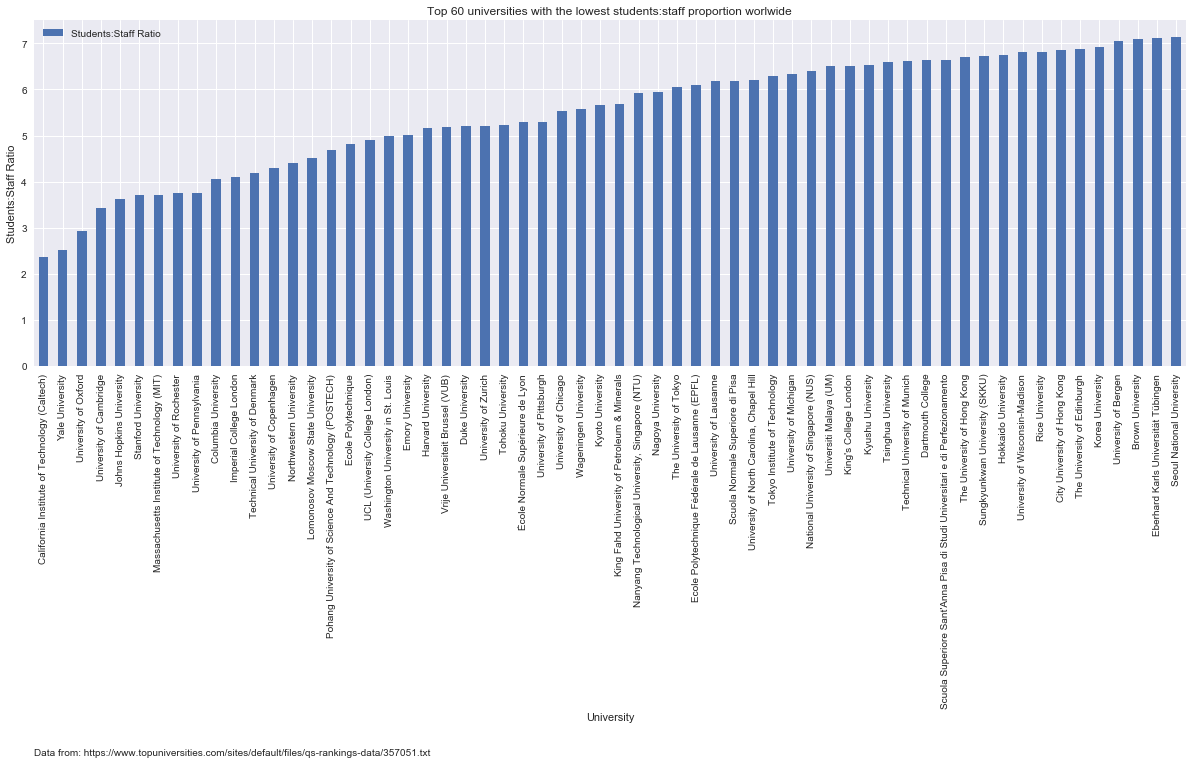

In [19]:
top = 60
plot_top_n(dataQS, 'Students:Staff Ratio', top, True, 
           'Top ' + str(top) + ' universities with the lowest students:staff proportion worlwide', 
           'University', 'Students:Staff Ratio', url_QS)

The top-10 universities with the lowest *Students:Staff Ratio* are located in either Europe or North America, with roughly 4 or less students per staff. 

#### Top universities with the highest international students proportion

In [684]:
dataQS['Students international:Students Ratio'] = dataQS['number of international students'] / dataQS['number of students'] 

Inversely, the *Students international:Students Ratio* is sorted in decreasing order: a high proportion of international students is perceived as providing a higher interculturality in a university.

In [685]:
#dataQS.sort_values('Students international:Students Ratio', ascending=False).head(3)

Again, for readability, we only display the top-60 universities scoring highest in the *Students international:Students Ratio*.

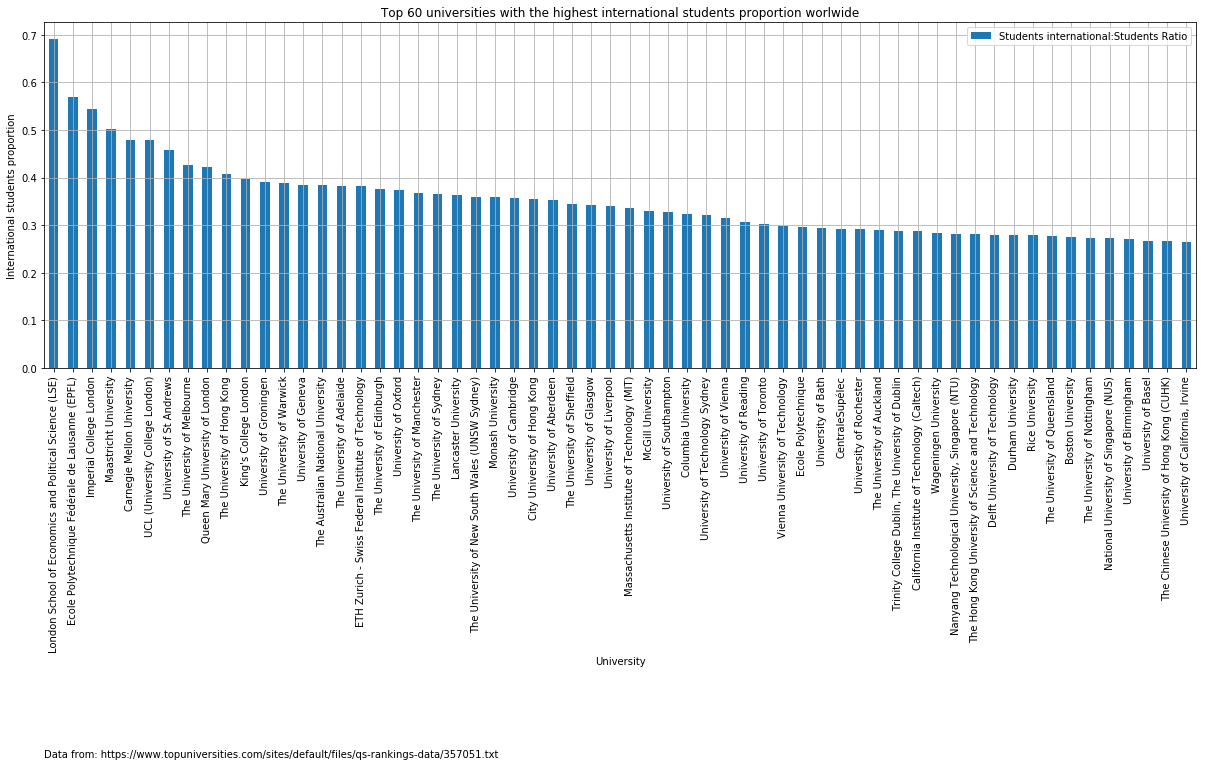

In [686]:
top = 60
plot_top_n(dataQS, 'Students international:Students Ratio', top, False, 
         'Top ' + str(top) + ' universities with the highest international students proportion worlwide',
         'University', 'International students proportion', url_QS)

The top-5 universities with the highest international students proportion are located in Europe or North America. Among the top-10 however, one can be found in Australia and the other in Hong Kong.
For the top-4 universities, the international students proportion exceeds 50%.

### Ratio of faculty members and international students (by region)

In order to be able to plot the *Students:Staff Ratio* and the *Students internationalStudents Ratio* by region and by country, the *regions* and the *countries* are sorted in lexicographical order and mapped to a numerical range beforehand.

In [687]:
dataQS_tmp = dataQS.copy()

In [688]:
sorted_regions_QS = sorted(dataQS['region'].unique(), reverse=True)
mapping = {i:sorted_regions_QS.index(i) for i in sorted_regions_QS}
dataQS_tmp['region'] = dataQS['region'].map(mapping)

In [689]:
sorted_countries_QS = sorted(dataQS['country'].unique(), reverse=False)
mapping = {i:sorted_countries_QS.index(i) for i in sorted_countries_QS}
dataQS_tmp['country'] = dataQS['country'].map(mapping)

#### *Students:Staff Ratio* by region

Complete list of the top-200 universities, sorted by region and by *Students:Staff Ratio*

In [690]:
#dataQS.groupby("region").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True))

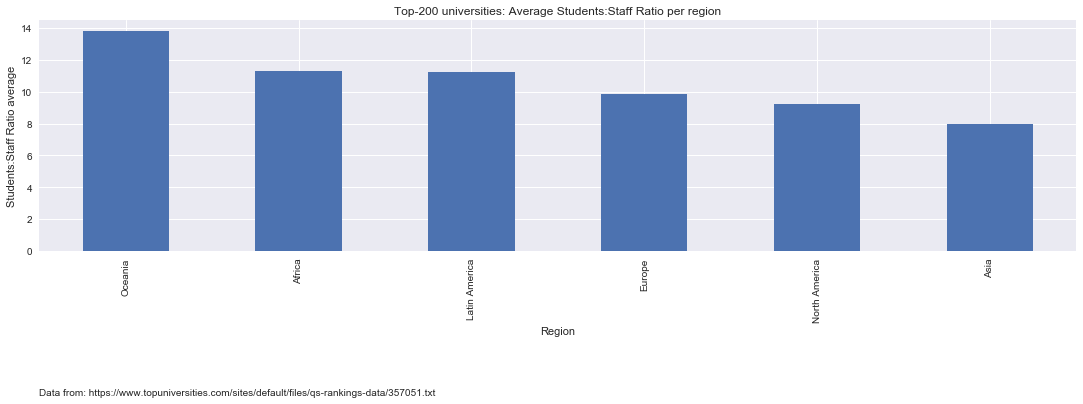

In [27]:
average_plot(dataQS, 'Students:Staff Ratio', 'region', 'Top-200 universities: Average Students:Staff Ratio per region',
             'Region', 'Students:Staff Ratio average', url_QS)

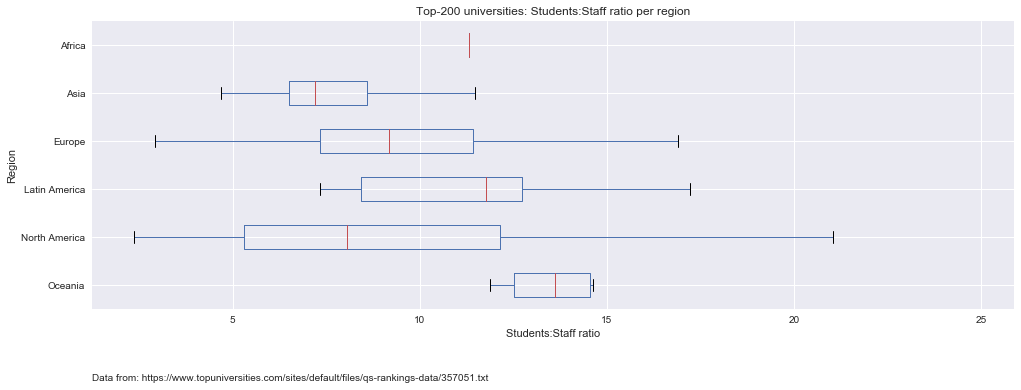

In [28]:
boxplot(dataQS, 'Students:Staff Ratio', 'region', 'Top-200 universities: Students:Staff ratio per region', 
        'Students:Staff ratio', 'Region', 'horizontal', url_QS)

In [691]:
source = ColumnDataSource(data=dict(
    y=dataQS_tmp['region'],
    x=dataQS['Students:Staff Ratio'],
    title=dataQS['title'],
    region=dataQS['region'],
    ratio=dataQS['Students:Staff Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Region', '@region'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Top-200 universities: Students:Staff ratio per region', 'Students:Staff ratio', 'Region',
                    '', sorted_regions_QS,
                   'horizontal', url_QS)

Among the top-200 universities, it is in Europe, North America and Asia that the *Students:Staff Ratio* seems to be the lowest on average. At the same time, Europe and North America also display a larger variance: the top-3 universities with the highest *Students:Staff Ratio* are located in Europe, and the top-8 in Europe or North America. The universities with the highest *Students:Staff Ratio* however can be found in Europe as well.
On average, it is the top universities in Asia which have the lowest *Students:Staff Ratio*, with the majority of them being in Japan.

#### *Students international:Students Ratio* by region

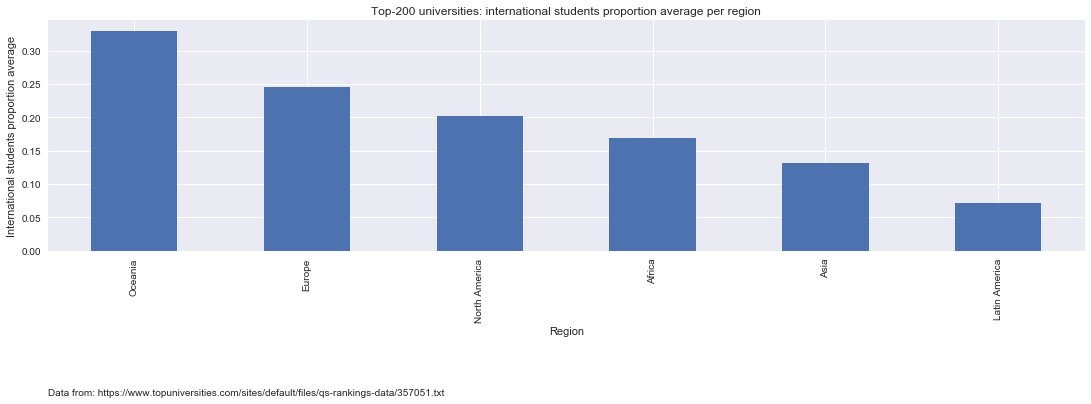

In [30]:
average_plot(dataQS, 'Students international:Students Ratio', 'region',
             'Top-200 universities: international students proportion average per region',
             'Region', 'International students proportion average', url_QS)

In [31]:
#dataQS.groupby("region").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=False))

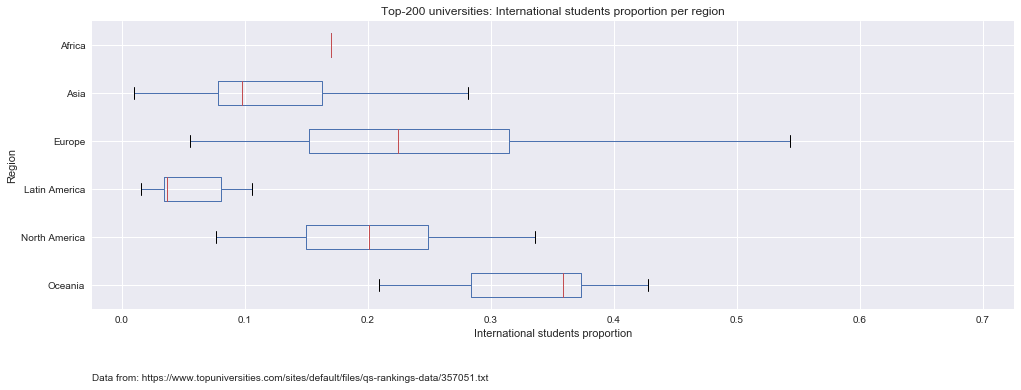

In [32]:
boxplot(dataQS, 'Students international:Students Ratio', 'region',
        'Top-200 universities: International students proportion per region',
        'International students proportion', 'Region',
        'horizontal', url_QS)

In [692]:
source = ColumnDataSource(data=dict(
    y=dataQS_tmp['region'],
    x=dataQS['Students international:Students Ratio'],
    title=dataQS['title'],
    region=dataQS['region'],
    ratio=dataQS['Students international:Students Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Region', '@region'),
    ('Rank', '$index'),
    ('International students proportion', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Top-200 universities: International students proportion per region', 'International students proportion', 'Region',
                   '', sorted_regions_QS,
                   'horizontal', url_QS)

We see that the top universities with an international students proportion higher than 50% are all located in Europe. 
North America displays a rather low variance around an average score of 20%, except for one university (the Carnegie Mellon University) which almost reaches the 50% too.

The top universities in Latin America have a rather low international students proportion compared to the other world regions.
On average, Oceania scores highest, with allthe top universities having an international students proportion greater than 20%. 
Still, there are only 10 universities which are listed in the QS ranking for Oceania; North America and Europe each have at least two dozen of them.

### Ratio of faculty members and international students (by country)

#### *Students:Staff Ratio* by country

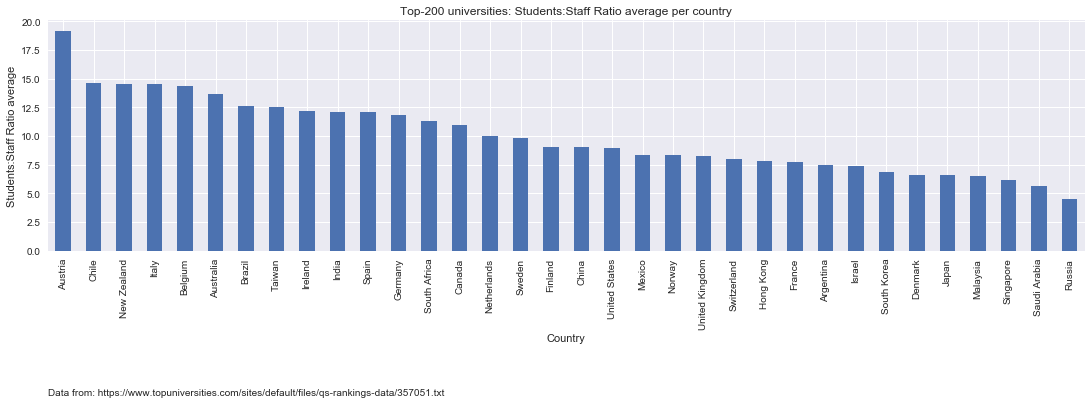

In [34]:
average_plot(dataQS, 'Students:Staff Ratio', 'country',
             'Top-200 universities: Students:Staff Ratio average per country',
             'Country', 'Students:Staff Ratio average', url_QS)

In [35]:
#dataQS.groupby("country").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True))

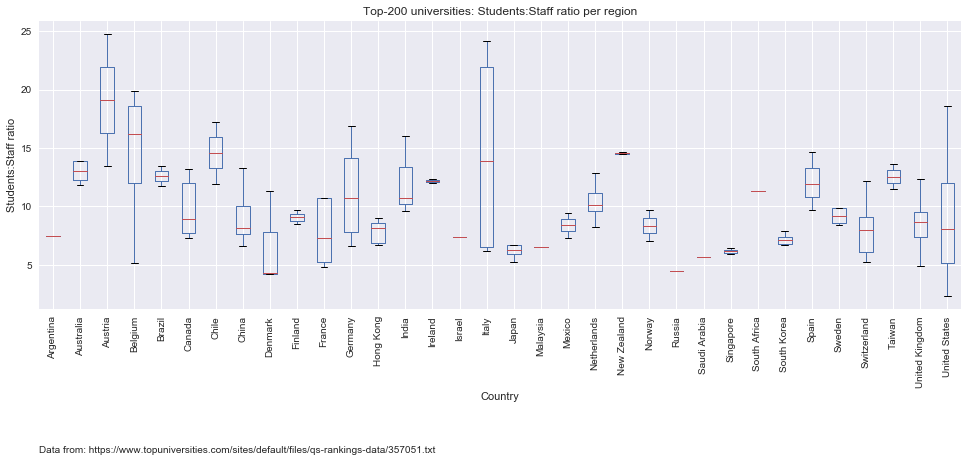

In [36]:
boxplot(dataQS, 'Students:Staff Ratio', 'country',
        'Top-200 universities: Students:Staff ratio per region',
        'Country', 'Students:Staff ratio',
        'vertical', url_QS)

In [693]:
source = ColumnDataSource(data=dict(
    x=dataQS_tmp['country'],
    y=dataQS['Students:Staff Ratio'],
    title=dataQS['title'],
    country=dataQS['country'],
    ratio=dataQS['Students:Staff Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Country', '@country'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Top-200 universities: Students:Staff ratio per country', 'Country', 'Students:Staff ratio',
                   sorted_countries_QS, '',
                   'vertical', url_QS)

As pointed out previously, the top universities with the highest international students proportion are mostly in Europe and North America, with a score close to 4 or less.
In comparison, among the top-200 universities of the QS ranking, the highest *Students:Staff Ratio*, in the Vienna University of Technology, is almost 25.

#### *Students international:Students Ratio* by country

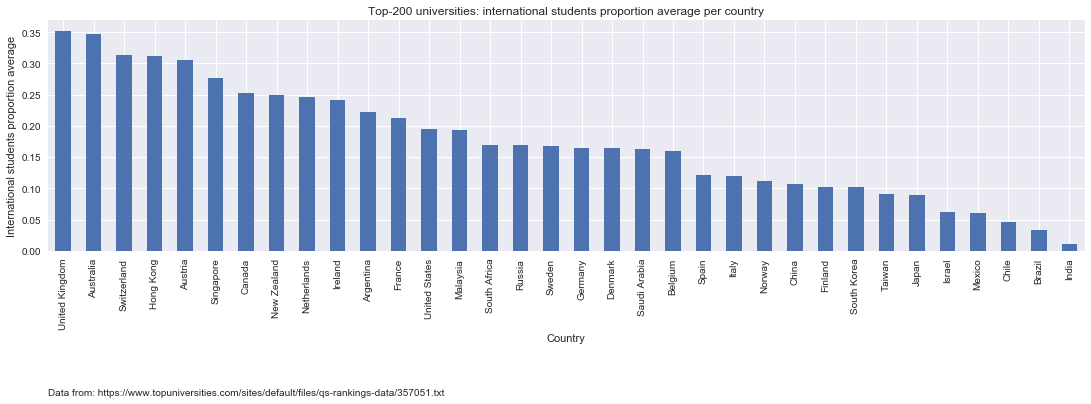

In [38]:
average_plot(dataQS, 'Students international:Students Ratio', 'country',
             'Top-200 universities: international students proportion average per country',
             'Country', 'International students proportion average', url_QS)

In [39]:
#dataQS.groupby("country").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=False))

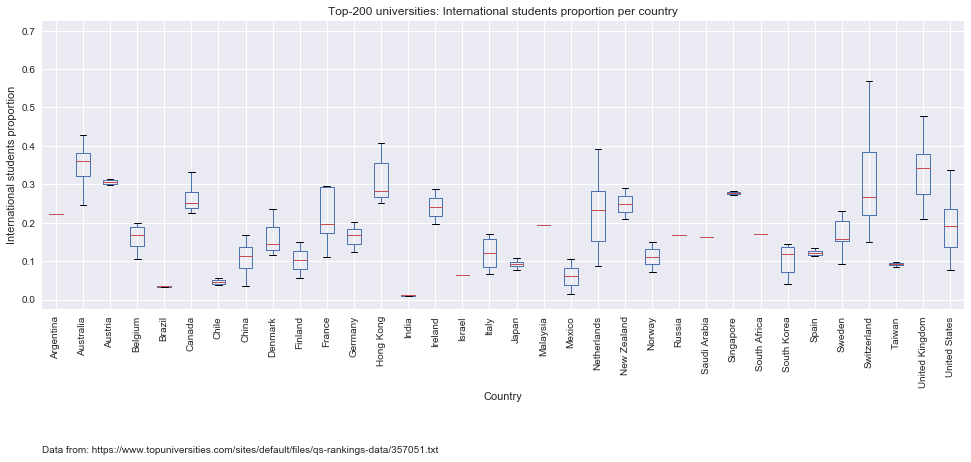

In [40]:
boxplot(dataQS, 'Students international:Students Ratio', 'country',
       'Top-200 universities: International students proportion per country',
        'Country', 'International students proportion',
        'vertical', url_QS)

In [694]:
source = ColumnDataSource(data=dict(
    x=dataQS_tmp['country'],
    y=dataQS['Students international:Students Ratio'],
    title=dataQS['title'],
    country=dataQS['country'],
    ratio=dataQS['Students international:Students Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Country', '@country'),
    ('Rank', '$index'),
    ('International students proportion', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Top-200 universities: International students proportion per country', 'Country', 'International students proportion',
                   sorted_countries_QS, '',
                   'vertical', url_QS)

The top-2 countries with the highest average international students proportion are the United Kingdom and Australia. 
Among the top-10, one can also find Hong Kong, Singapore or Canada: english-speaking countries seem to be a popular destination for international students.

The 3 universities with the lowest *Students international:Students Ratio* are in India, with a proportion of barely 1% or less of international students.

## Conclusion

Most of the top universities listed by the QS ranking are located in Europe and North America, and are either in the United Kingdom or in the United States.
Therefore, it may be sometimes difficult to draw a conclusion which is representative of the whole region.

It is difficult as well to compare the *Students:Staff Ratio* and *Students international:Students Ratio* of the top universities in Africa, because the QS ranking listed only a single one.


## 2 - Times Higher Education University Ranking
### www.timeshighereducation.com

Same schema go to : "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

And we have the data at json format

In [695]:
url_THE = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

r =  requests.get(url_THE)
print(r.status_code)
import json
from io import StringIO
json = json.load(StringIO(r.text))
dataTHE = pd.DataFrame(json['data'])

200


In [696]:
#dataTHE.head()

We drop the columns which are not relevant for us.

In [697]:
dataTHE.drop("record_type",axis=1,inplace=True)
dataTHE.drop("aliases",axis=1,inplace=True)
dataTHE.drop("subjects_offered",axis=1,inplace=True)
dataTHE.drop("scores_teaching_rank",axis=1,inplace=True)
dataTHE.drop("scores_citations",axis=1,inplace=True)
dataTHE.drop("scores_industry_income",axis=1,inplace=True)
dataTHE.drop("scores_citations_rank",axis=1,inplace=True)
dataTHE.drop("scores_industry_income_rank",axis=1,inplace=True)
dataTHE.drop("scores_international_outlook",axis=1,inplace=True)
dataTHE.drop("scores_research",axis=1,inplace=True)
dataTHE.drop("scores_teaching",axis=1,inplace=True)
dataTHE.drop("scores_research_rank",axis=1,inplace=True)
dataTHE.drop("scores_international_outlook_rank",axis=1,inplace=True)

#dataTHE.head()

For convenience, we rename the *name*, *location*, *stats_student_staff_ratio* and *stats_pc_intl_students* columns into *title*, *country*, *Students:Staff Ratio* and *Students international:Students Ratio* respectively, so that they match the corresponding columns in the QS ranking data.

In [698]:
dataTHE.rename(columns={'stats_student_staff_ratio':'Students:Staff Ratio'}, inplace=True)
dataTHE.rename(columns={'stats_pc_intl_students':'Students international:Students Ratio'}, inplace=True)
dataTHE.rename(columns={'name':'title'}, inplace=True)
dataTHE.rename(columns={'location':'country'}, inplace=True)

For the subsequent analysis, we only keep the top-200 universities according to the THE ranking.

In [699]:
dataTHE = dataTHE.head(200)

The *Students international:Students Ratio* value is currently a percentage, stored as an *Object*. We therefore transform it into a numerical value, so that its manipulation becomes more convenient.
For the same reason, we convert the *Students:Staff Ratio* into a numerical value as well.

In [700]:
dataTHE['Students international:Students Ratio'] = dataTHE['Students international:Students Ratio'].apply(lambda x: int(x.split('%')[0]) / 100)
dataTHE['Students:Staff Ratio'] = pd.to_numeric(dataTHE['Students:Staff Ratio'])

Complete list of the top-200 universites according to the *Times Higher Education* ranking

In [701]:
dataTHE.head()

,country,member_level,title,nid,rank,rank_order,scores_overall,scores_overall_rank,stats_female_male_ratio,stats_number_students,Students international:Students Ratio,Students:Staff Ratio,url
0,United Kingdom,0,University of Oxford,468,1,10,94.3,10,46 : 54,"20,409",0.38,11.2,/world-university-rankings/university-oxford
1,United Kingdom,0,University of Cambridge,470,2,20,93.2,20,45 : 55,"18,389",0.35,10.9,/world-university-rankings/university-cambridge
2,United States,0,California Institute of Technology,128779,=3,30,93.0,30,31 : 69,"2,209",0.27,6.5,/world-university-rankings/california-institut...
3,United States,11,Stanford University,467,=3,40,93.0,40,42 : 58,"15,845",0.22,7.5,/world-university-rankings/stanford-university
4,United States,0,Massachusetts Institute of Technology,471,5,50,92.5,50,37 : 63,"11,177",0.34,8.7,/world-university-rankings/massachusetts-insti...


### 2.1 Ratio of faculty members and international students (worldwide)

Like for the QS ranking, for readability, we only display the top-60 universities.

As before, the *Students:Staff Ratio* is sorted in increasing order (a high number of staff per student is perceived as providing higher quality education).

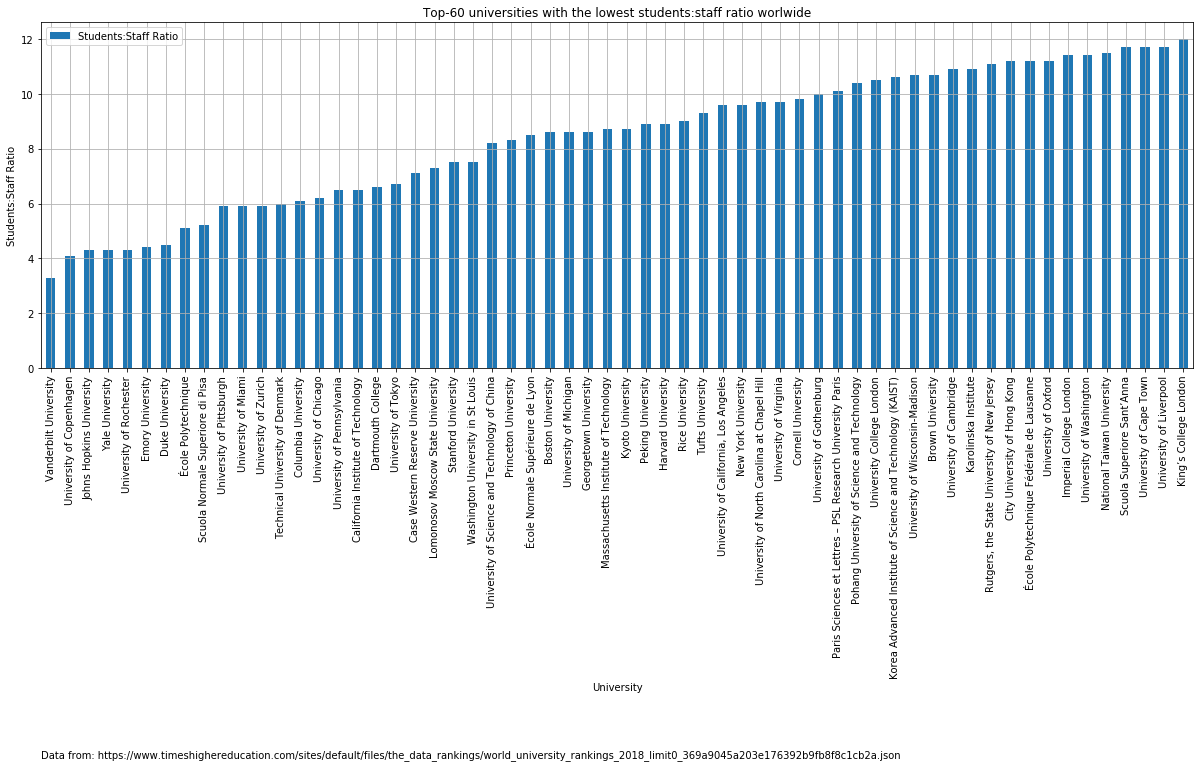

In [702]:
top = 60
plot_top_n(dataTHE, 'Students:Staff Ratio', top, True, 
         'Top-' + str(top) + ' universities with the lowest students:staff ratio worlwide',
         'University', 'Students:Staff Ratio', url_THE)

Again, the *Students international:Students Ratio* is sorted in decreasing order: a high proportion of international students is perceived as providing a higher interculturality in a university.

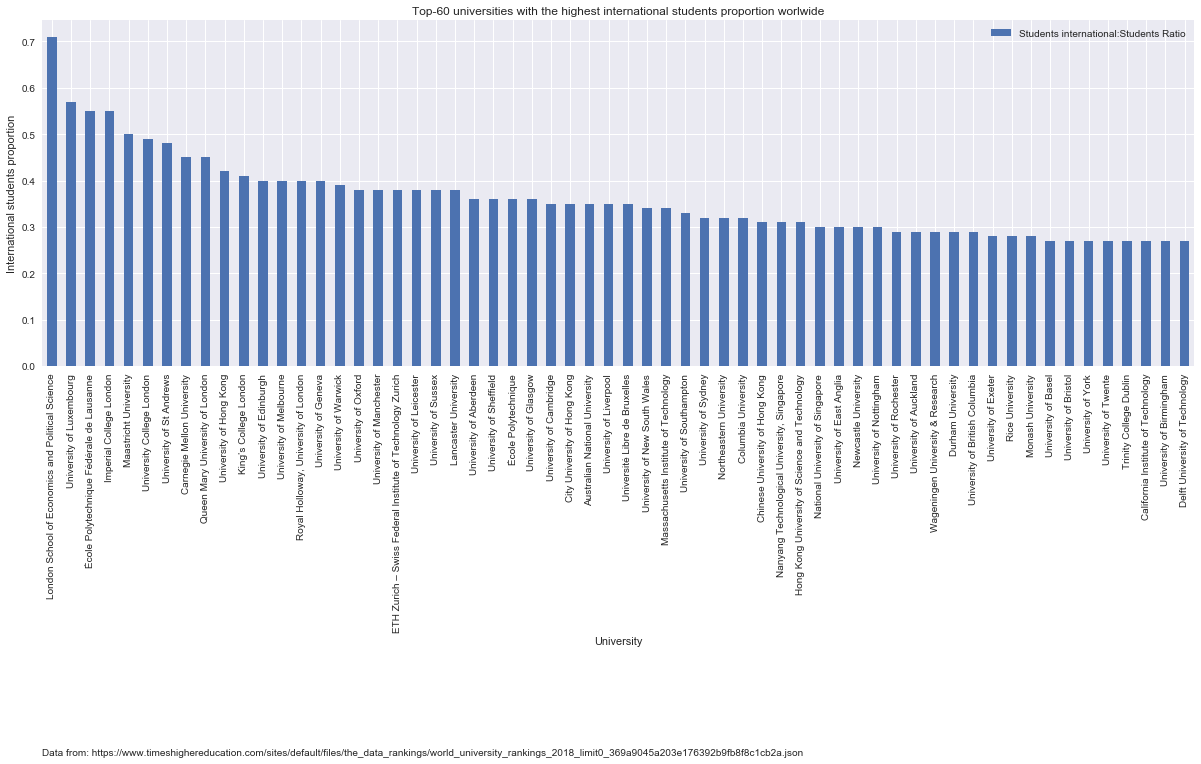

In [50]:
top = 60
plot_top_n(dataTHE, 'Students international:Students Ratio', top, False, 
         'Top-' + str(top) + ' universities with the highest international students proportion worlwide',
         'University', 'International students proportion', url_THE)

Interestingly, for the top-10 universities with the lowest *Students:Staff Ratio*, the two rankings only have three universities in common (the Yale University (USA), the University of Rochester (USA) and the Ecole Polytechnique (France)).

The results for the international students proportion are more consistent: 9 universities out of 10 are found in the both top-10s. In the QS ranking, the University of Melbourne ranks at position 8, but only 13 in the THE ranking. The University of Luxembourg, which ranks second in the THE ranking, happens to not appear in the top-200 universities of the QS ranking though.

### 2.2 Ratio of faculty members and international students (by region)

We repeat the lexicographical sorting and mapping to to a numerical range for the *region* and *country* columns of the data from Times Higher Education.
The ranking in Times Higher Education however lacks a *region* field. We use the same country to region mapping as for the QS ranking.

In [703]:
country_region_pairs = dataQS[['country', 'region']].drop_duplicates()
country_to_region = {country:region for (country, region) in zip(country_region_pairs['country'],country_region_pairs['region'])}

Among the countries where the top-200 universities are found, one of them - Luxembourg - does not appear in the QS ranking though. We therefore manualy map it in the dictionary.

In [704]:
only_THE_countries = dataTHE['country'][~(dataTHE['country'].isin(dataQS['country']))]
print(only_THE_countries)

178            Luxembourg
193    Russian Federation
Name: country, dtype: object


In [705]:
country_to_region['Luxembourg'] = 'Europe'

As for the 'Russian Federation', we replace it with 'Russia', so that the country names match for both rankings.

In [706]:
dataTHE.replace('Russian Federation', 'Russia', inplace=True)

We then add the new *region* column to the original dataframe using the previously created mapping.

In [707]:
dataTHE['region'] = dataTHE['country'].map(country_to_region)

The THE ranking does not list universities from 'Latin America':

In [708]:
dataTHE['region'].unique()

array(['Europe', 'North America', 'Asia', 'Oceania', 'Africa'], dtype=object)

In [709]:
dataTHE_tmp = dataTHE.copy()

In [710]:
sorted_regions_THE = sorted(dataTHE['region'].unique(), reverse=True)
mapping = {i:sorted_regions_THE.index(i) for i in sorted_regions_THE}
dataTHE_tmp['region'] = dataTHE['region'].map(mapping)

In [711]:
sorted_countries_THE = sorted(dataTHE['country'].unique(), reverse=False)
mapping = {i:sorted_countries_THE.index(i) for i in sorted_countries_THE}
dataTHE_tmp['country'] = dataTHE['country'].map(mapping)

#### *Students:Staff Ratio* by region

Complete list of the top-200 universities, sorted by region and by *Students:Staff Ratio*

In [60]:
#dataTHE.groupby("region").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True)).head()

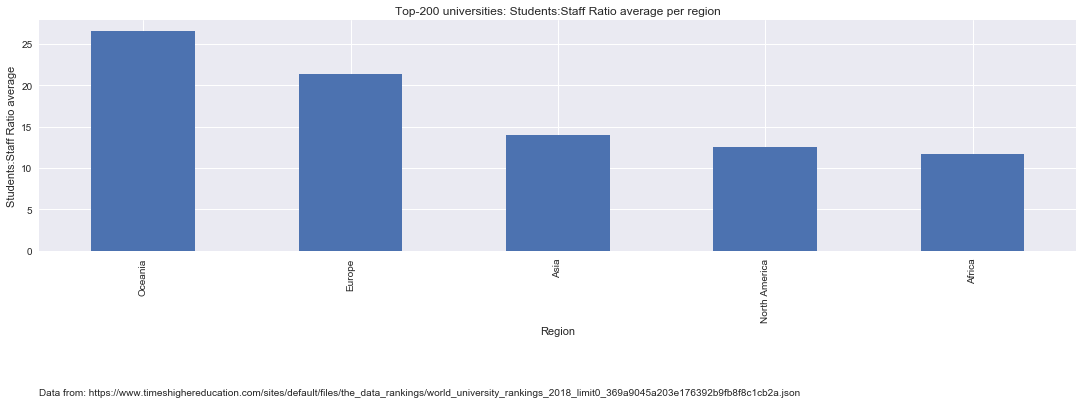

In [61]:
average_plot(dataTHE, 'Students:Staff Ratio', 'region',
             'Top-200 universities: Students:Staff Ratio average per region', 
             'Region', 'Students:Staff Ratio average', url_THE)

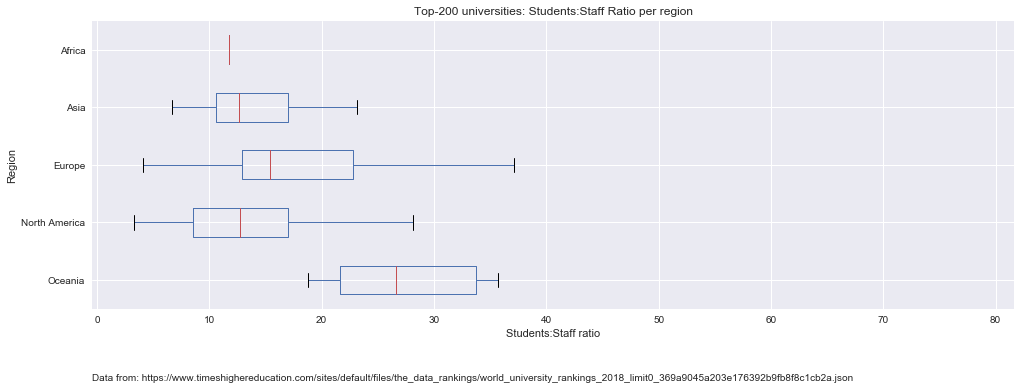

In [62]:
boxplot(dataTHE, 'Students:Staff Ratio', 'region','Top-200 universities: Students:Staff Ratio per region', 
        'Students:Staff ratio', 'Region', 'horizontal', url_THE)

In [712]:
source = ColumnDataSource(data=dict(
    y=dataTHE_tmp['region'],
    x=dataTHE['Students:Staff Ratio'],
    title=dataTHE['title'],
    region=dataTHE['region'],
    ratio=dataTHE['Students:Staff Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Region', '@region'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Students:Staff ratio per region', 'Students:Staff atio', 'Region',
                    '', sorted_regions_THE,
                   'horizontal', url_THE)

In the THE ranking, the values for the *Students:Satff Ratio* are much more spread out compared to the QS ranking, particularly regarding the universities in Europe: the QS ranking indicates a *Students:Staff Ratio* of roughly 24 for the Freie Universität Berlin, but the THE ranking a value of 57, which is more than twice as much.

#### *Students international:Students Ratio* by region

Complete list of the top-200 universities, sorted by region and by *Students:Staff Ratio*

In [64]:
#dataTHE.groupby("region").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=True))

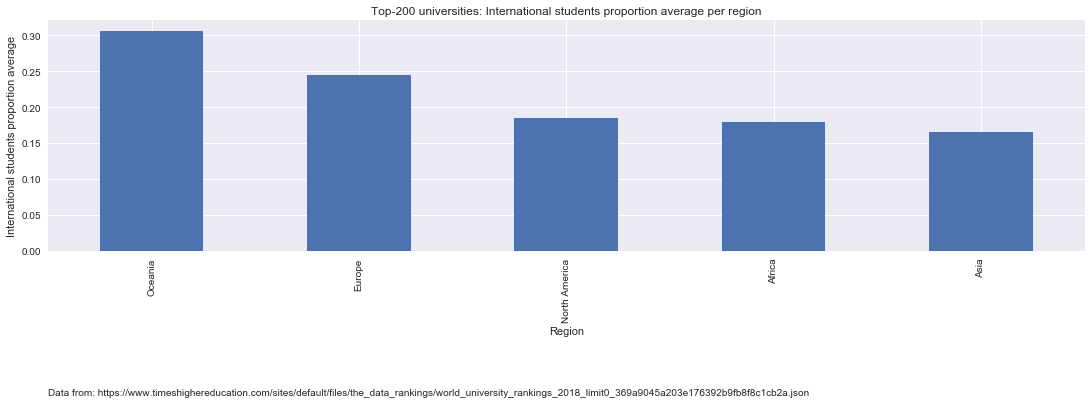

In [65]:
average_plot(dataTHE, 'Students international:Students Ratio', 'region',
             'Top-200 universities: International students proportion average per region', 
             'Region', 'International students proportion average', url_THE)

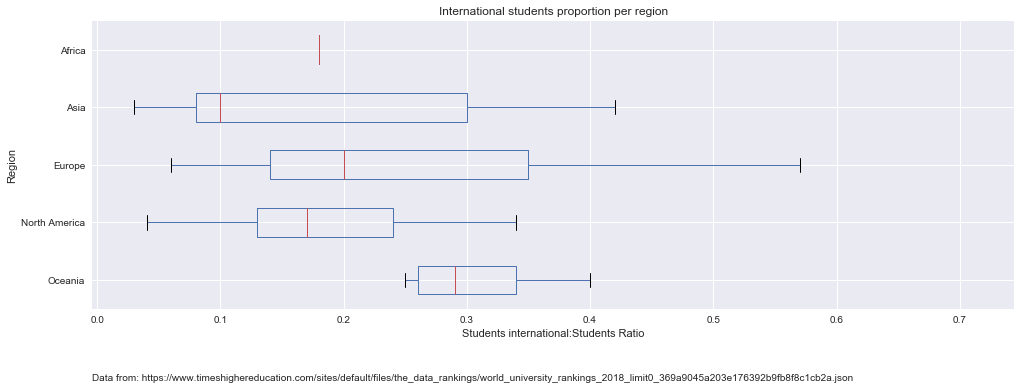

In [66]:
boxplot(dataTHE, 'Students international:Students Ratio', 'region',
        'International students proportion per region', 'Students international:Students Ratio', 'Region',
        'horizontal', url_THE)

In [713]:
source = ColumnDataSource(data=dict(
    y=dataTHE_tmp['region'],
    x=dataTHE_tmp['Students international:Students Ratio'],
    title=dataTHE['title'],
    region=dataTHE['region'],
    ratio=dataTHE['Students international:Students Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Region', '@region'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Students international:Students Ratio per region', 'Students international:Students Ratio', 'Region',
                    '', sorted_regions_THE,
                   'horizontal', url_THE)

For the international students proportion per region, except for the fact that no university represents Lain America in the THE ranking, the two rankings are consistent.

### 2.3 Ratio of faculty members and international students (by country)

#### *Students:Staff Ratio* by country

Complete list of the top-200 universities, sorted by country and by *Students:Staff Ratio*

In [68]:
#dataTHE.groupby("country").apply(lambda x: x.sort_values(["Students:Staff Ratio"], ascending=True))

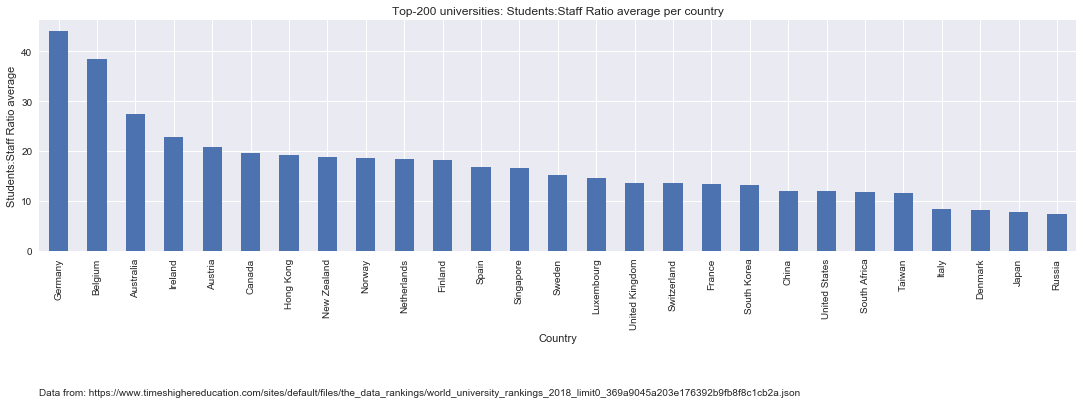

In [69]:
average_plot(dataTHE, 'Students:Staff Ratio', 'country',
             'Top-200 universities: Students:Staff Ratio average per country',
             'Country', 'Students:Staff Ratio average', url_THE)

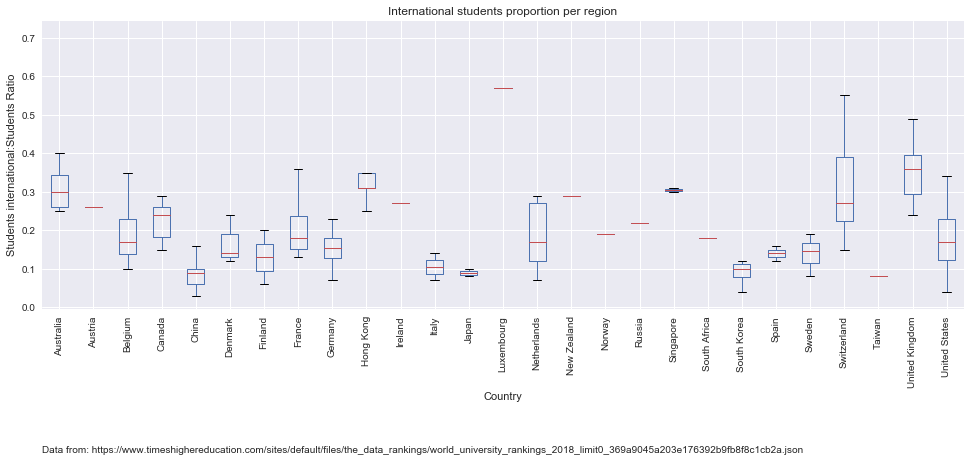

In [70]:
boxplot(dataTHE, 'Students international:Students Ratio', 'country',
        'International students proportion per region', 'Country', 'Students international:Students Ratio',
        'vertical', url_THE)

In [714]:
source = ColumnDataSource(data=dict(
    x=dataTHE_tmp['country'],
    y=dataTHE['Students:Staff Ratio'],
    title=dataTHE['title'],
    country=dataTHE['country'],
    ratio=dataTHE['Students:Staff Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Country', '@country'),
    ('Rank', '$index'),
    ('Students:Staff ratio', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'Students:Staff ratio per country', 'Country', 'Students:Staff ratio',
                    sorted_countries_THE, '',
                   'vertical', url_THE)

For some countries like Italy or Germany, the way the *Students:Staff Ratio* values are spread out differs quite a bit between the two rankings. This is also due to the fact that they did not select the same top-200 universities: the universities which are found in one ranking and not the other are often rather low ranked among the top-200.

#### *Students international:Students Ratio* by country

Complete list of the top-200 universities, sorted by countru and by *Students international:Students Ratio*

In [72]:
#dataTHE.groupby("country").apply(lambda x: x.sort_values(["Students international:Students Ratio"], ascending=True))

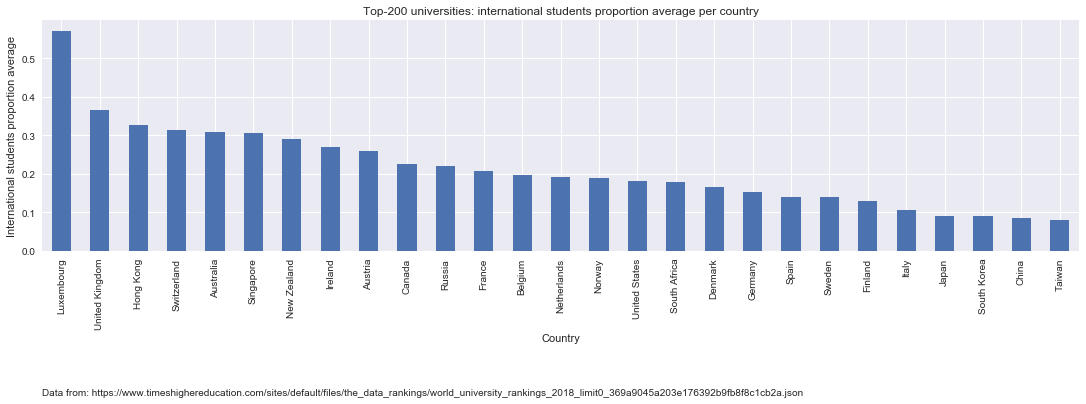

In [73]:
average_plot(dataTHE, 'Students international:Students Ratio', 'country',
             'Top-200 universities: international students proportion average per country',
             'Country', 'International students proportion average', url_THE)

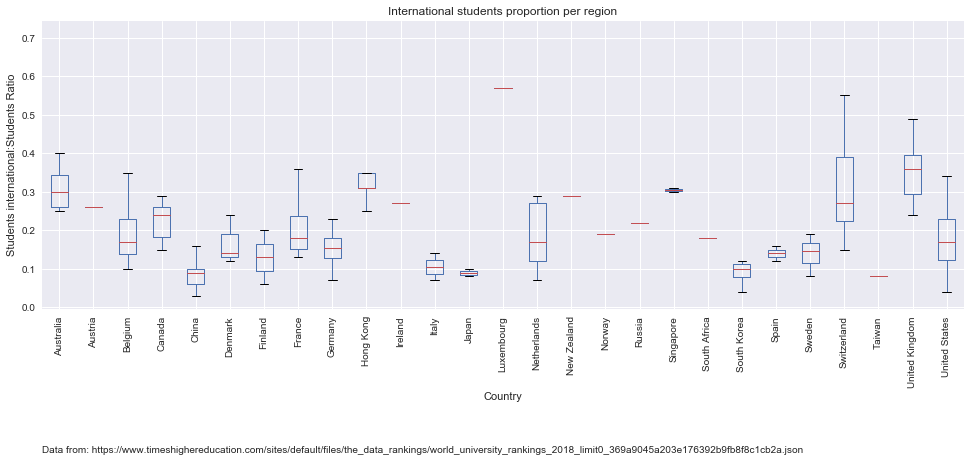

In [74]:
boxplot(dataTHE, 'Students international:Students Ratio', 'country',
        'International students proportion per region', 'Country', 'Students international:Students Ratio',
        'vertical', url_THE)

In [715]:
source = ColumnDataSource(data=dict(
    x=dataTHE_tmp['country'],
    y=dataTHE['Students international:Students Ratio'],
    title=dataTHE['title'],
    country=dataTHE['country'],
    ratio=dataTHE['Students international:Students Ratio']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Country', '@country'),
    ('Rank', '$index'),
    ('International students proportion', '@ratio')
])

hover_scatter_plot(source, hover, 
                   'International students proportion per country', 'Country', 'International students proportion',
                    sorted_countries_THE, '',
                   'vertical', url_THE)

As for the worldwide and by region cases, the results here are consistent with the QS ranking too. 
If we look at Switzerland, United Kingdom or United States for instance, where the same top universities tend to appear in both rankings, we see that the overall distribution, as well as the individual values per university, are very similar.

Conclusion
======


In general, regarding the number of international students, the two rankings seem in adequation. 

On the number of staff however, the two rankings do not have the same ranking, they do not seem to count the faculty members in the same way.

# 3 - Merging the QS and the THE rankings

For merging, we will merge on *title* and *country*. The only problem is that in one ranking the university name is in english and in the other one the name is in the university's origin country (e.g. french, spanish ...)

So we will use an algorithm of fuzzy token (fuzz.token_sort_ratio), it works on sentences like "Université de Machin". Moreover we translate some terms for a better efficiency:

Univedrsité -> University

Universitat -> University

We choose a threshold of 82 after some trying.


In [716]:
from fuzzywuzzy import fuzz

In [717]:
def get_closest_match(x, list_strings):
    """return for one x the best university which matches with the token_sort_ratio algorithm distance"""
    best_match = x
    highest_jw = 0

    for current_string in list_strings:
        current_score = fuzz.token_sort_ratio(x, current_string)
        # for each univertisy calculate the matching score

        # use a minimal threshold and same country to be sure we have exactly the same university
        if(current_score > highest_jw and  current_score>84): # thresold and country match
            if(dataTHEcpy.loc[dataTHEcpy.title_THE==current_string].country.iloc[0] == dataQScpy.loc[dataQScpy.title_QS==x].country.iloc[0] ) : 
                highest_jw = current_score
                best_match = current_string
        
        # for debuging purpose
        if('kong' in x):
            print(best_match)
            print(x)
            print(highest_jw)
            
    return best_match

We work on copies of the data

In [718]:
dataTHEcpy = dataTHE.copy()
dataQScpy = dataQS.copy()

And drop data which is not relevant here

In [719]:
dataQScpy.drop('url',axis=1,inplace=True)
dataQScpy.drop('nid',axis=1,inplace=True)

dataTHEcpy.drop('url',axis=1,inplace=True)
dataTHEcpy.drop('scores_overall',axis=1,inplace=True)
dataTHEcpy.drop('stats_female_male_ratio',axis=1,inplace=True)
dataTHEcpy.drop('nid',axis=1,inplace=True)
dataTHEcpy.drop('member_level',axis=1,inplace=True)

We manually make some translations

In [720]:
dataQScpy.title = dataQScpy.title.str.replace('Université', 'University')
dataQScpy.title = dataQScpy.title.str.replace('et ', 'and ')
dataQScpy.title = dataQScpy.title.str.replace('Universitat', 'University')
dataQScpy.title = dataQScpy.title.str.replace('Autònoma', 'Autonomous')

In [721]:
dataTHEcpy.rename(columns={'stats_number_students':'number of students'}, inplace=True) 

We rename the *title* of the QS data into *title_QS* and the *title* of the THE data into *title_THE* before merging the two dataframes. This also allows us to identify which universities do not have an equivalent in the other ranking.

In [722]:
dataQScpy.rename(columns={'title':'title_QS'}, inplace=True)
dataTHEcpy.rename(columns={'title':'title_THE'}, inplace=True);

We now apply the closest match on the QS ranking *title_QS* so that we can merge both *title_QS* and *title_THE*

In [723]:
dataQScpy.title_QS = dataQScpy.title_QS.map(lambda x: get_closest_match(x, dataTHEcpy.title_THE))

We verify there are not two universities which match the same one

In [724]:
print('Number of distinct universities in the QS ranking after matching:', len(dataQScpy.title_QS.unique()))

Number of distinct universities in the QS ranking after matching: 200


Merging

In [725]:
merged = dataQScpy.merge(dataTHEcpy,how='outer',left_on='title_QS',right_on='title_THE')

This is the complete list of the universities which do not have an equivalent in the other ranking

In [726]:
merged[merged.title_QS.isnull() | merged.title_THE.isnull() ]

,cc,country_x,rank_display,region_x,score,title_QS,number of students_x,number of international students,number of faculty members,number of international faculty members,...,Students international:Students Ratio_x,country_y,title_THE,rank,rank_order,scores_overall_rank,number of students_y,Students international:Students Ratio_y,Students:Staff Ratio_y,region_y
42,FR,France,43,Europe,79.9,"Ecole normale supérieure, Paris",1907.0,374.0,178.0,75.0,...,0.196120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,AU,Australia,45,Oceania,78.9,The University of New South Wales (UNSW Sydney),39784.0,14292.0,2924.0,1612.0,...,0.359240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,JP,Japan,56,Asia,74.8,Tokyo Institute of Technology,9832.0,1071.0,1563.0,191.0,...,0.108930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,JP,Japan,63,Asia,72.1,Osaka University,22760.0,2106.0,2814.0,296.0,...,0.092531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,DE,Germany,66,Europe,70.8,Ludwig-Maximilians-Universität München,35055.0,5084.0,3274.0,674.0,...,0.145029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,DE,Germany,68,Europe,70.4,Ruprecht-Karls-Universität Heidelberg,28852.0,5298.0,3908.0,756.0,...,0.183627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,AR,Argentina,75,Latin America,69.1,Universidad de Buenos Aires (UBA),122301.0,27109.0,16421.0,3165.0,...,0.221658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,JP,Japan,=76,Asia,69.0,Tohoku University,17827.0,1604.0,3411.0,264.0,...,0.089976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,IE,Ireland,88,Europe,65.7,"Trinity College Dublin, The University of Dublin",14961.0,4311.0,1249.0,544.0,...,0.288149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,KR,South Korea,=90,Asia,65.5,Korea University,25892.0,3638.0,3745.0,339.0,...,0.140507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we can inspect for both rankings the exact name of the universities did not found their equivalent in the other ranking

In [727]:
print(sorted(merged[merged.title_QS.isnull()]['title_THE']))
print(sorted(merged[merged.title_THE.isnull()]['title_QS']))

['Arizona State University', 'Case Western Reserve University', 'Charité - Universitätsmedizin Berlin', 'Free University of Berlin', 'Georgetown University', 'Heidelberg University', 'Indiana University', 'Karolinska Institute', 'LMU Munich', 'Northeastern University', 'Paris Sciences et Lettres – PSL Research University Paris', 'Paris-Sorbonne University – Paris 4', 'Paris-Sud University', 'Pompeu Fabra University', 'Radboud University Nijmegen', 'Royal Holloway, University of London', 'Rutgers, the State University of New Jersey', 'Scuola Superiore Sant’Anna', 'TU Dresden', 'Technical University of Berlin', 'Tilburg University', 'Trinity College Dublin', 'Tufts University', 'Ulm University', 'University of Alabama at Birmingham', 'University of Arizona', 'University of Bonn', 'University of California, Riverside', 'University of California, Santa Cruz', 'University of Cologne', 'University of Dundee', 'University of East Anglia', 'University of Erlangen-Nuremberg', 'University of Fre

In [728]:
print('Number of universities with no QS --> THE equivalent: ', len(merged[merged.title_THE.isnull()]))
print('Number of universities with no THE --> QS equivalent: ', len(merged[merged.title_QS.isnull()]))

Number of universities with no QS --> THE equivalent:  51
Number of universities with no THE --> QS equivalent:  51


So we see that 51 universities of www.topuniversities.com  do not have an equivalent in  www.timeshighereducation.com, and that 51 universities of www.timeshighereducation.com do not have an equivalent in www.topuniversities.com.

In [729]:
print(dataQS[dataQS['title'].str.contains('Cologne')]['title'] )

Series([], Name: title, dtype: object)


In [730]:
print(dataTHE[dataTHE['title'].str.contains("Cologne")]['title'])

144    University of Cologne
Name: title, dtype: object


In [731]:
mergednotnull = merged[~(merged.title_QS.isnull() | merged.title_THE.isnull()) ].copy()

Complete list of the universities for which a match was found in both rakings

In [732]:
mergednotnull

,cc,country_x,rank_display,region_x,score,title_QS,number of students_x,number of international students,number of faculty members,number of international faculty members,...,Students international:Students Ratio_x,country_y,title_THE,rank,rank_order,scores_overall_rank,number of students_y,Students international:Students Ratio_y,Students:Staff Ratio_y,region_y
0,US,United States,1,North America,100.0,Massachusetts Institute of Technology,11067.0,3717.0,2982.0,1679.0,...,0.335863,United States,Massachusetts Institute of Technology,5,50,50,"11,177",0.34,8.7,North America
1,US,United States,2,North America,98.7,Stanford University,15878.0,3611.0,4285.0,2042.0,...,0.227422,United States,Stanford University,=3,40,40,"15,845",0.22,7.5,North America
2,US,United States,3,North America,98.4,Harvard University,22429.0,5266.0,4350.0,1311.0,...,0.234785,United States,Harvard University,6,60,60,"20,326",0.26,8.9,North America
3,US,United States,4,North America,97.7,California Institute of Technology,2255.0,647.0,953.0,350.0,...,0.286918,United States,California Institute of Technology,=3,30,30,"2,209",0.27,6.5,North America
4,GB,United Kingdom,5,Europe,95.6,University of Cambridge,18770.0,6699.0,5490.0,2278.0,...,0.356899,United Kingdom,University of Cambridge,2,20,20,"18,389",0.35,10.9,Europe
5,GB,United Kingdom,6,Europe,95.3,University of Oxford,19720.0,7353.0,6750.0,2964.0,...,0.372870,United Kingdom,University of Oxford,1,10,10,"20,409",0.38,11.2,Europe
6,GB,United Kingdom,7,Europe,94.6,University College London,31080.0,14854.0,6345.0,2554.0,...,0.477928,United Kingdom,University College London,16,160,160,"30,304",0.49,10.5,Europe
7,GB,United Kingdom,8,Europe,93.7,Imperial College London,16090.0,8746.0,3930.0,2071.0,...,0.543567,United Kingdom,Imperial College London,8,80,80,"15,857",0.55,11.4,Europe
8,US,United States,9,North America,93.5,University of Chicago,13557.0,3379.0,2449.0,635.0,...,0.249244,United States,University of Chicago,9,90,90,"13,525",0.25,6.2,North America
9,CH,Switzerland,10,Europe,93.3,ETH Zurich – Swiss Federal Institute of Techno...,19815.0,7563.0,2477.0,1886.0,...,0.381681,Switzerland,ETH Zurich – Swiss Federal Institute of Techno...,=10,100,100,"19,233",0.38,14.6,Europe


Some cleaning

In [733]:
mergednotnull.drop('region_y',axis=1,inplace=True)
mergednotnull.drop('country_y',axis=1,inplace=True)
mergednotnull

,cc,country_x,rank_display,region_x,score,title_QS,number of students_x,number of international students,number of faculty members,number of international faculty members,Students:Staff Ratio_x,Students international:Students Ratio_x,title_THE,rank,rank_order,scores_overall_rank,number of students_y,Students international:Students Ratio_y,Students:Staff Ratio_y
0,US,United States,1,North America,100.0,Massachusetts Institute of Technology,11067.0,3717.0,2982.0,1679.0,3.711268,0.335863,Massachusetts Institute of Technology,5,50,50,"11,177",0.34,8.7
1,US,United States,2,North America,98.7,Stanford University,15878.0,3611.0,4285.0,2042.0,3.705484,0.227422,Stanford University,=3,40,40,"15,845",0.22,7.5
2,US,United States,3,North America,98.4,Harvard University,22429.0,5266.0,4350.0,1311.0,5.156092,0.234785,Harvard University,6,60,60,"20,326",0.26,8.9
3,US,United States,4,North America,97.7,California Institute of Technology,2255.0,647.0,953.0,350.0,2.366212,0.286918,California Institute of Technology,=3,30,30,"2,209",0.27,6.5
4,GB,United Kingdom,5,Europe,95.6,University of Cambridge,18770.0,6699.0,5490.0,2278.0,3.418944,0.356899,University of Cambridge,2,20,20,"18,389",0.35,10.9
5,GB,United Kingdom,6,Europe,95.3,University of Oxford,19720.0,7353.0,6750.0,2964.0,2.921481,0.372870,University of Oxford,1,10,10,"20,409",0.38,11.2
6,GB,United Kingdom,7,Europe,94.6,University College London,31080.0,14854.0,6345.0,2554.0,4.898345,0.477928,University College London,16,160,160,"30,304",0.49,10.5
7,GB,United Kingdom,8,Europe,93.7,Imperial College London,16090.0,8746.0,3930.0,2071.0,4.094148,0.543567,Imperial College London,8,80,80,"15,857",0.55,11.4
8,US,United States,9,North America,93.5,University of Chicago,13557.0,3379.0,2449.0,635.0,5.535729,0.249244,University of Chicago,9,90,90,"13,525",0.25,6.2
9,CH,Switzerland,10,Europe,93.3,ETH Zurich – Swiss Federal Institute of Techno...,19815.0,7563.0,2477.0,1886.0,7.999596,0.381681,ETH Zurich – Swiss Federal Institute of Techno...,=10,100,100,"19,233",0.38,14.6


4 - Correlations
======

In [734]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns,rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);

In [779]:
#plot_corr(mergednotnull.corr())

Maximum correlation value : 0.95


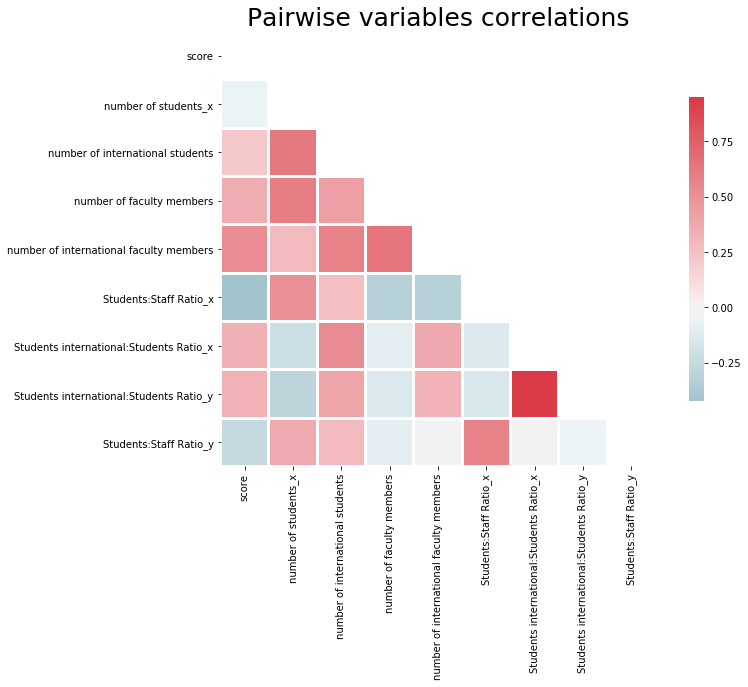

In [803]:
corr = mergednotnull.corr()
maxCorr = np.amax(corr.replace(1, 0, inplace = False).values)
print("Maximum correlation value : {:0.2f}".format(maxCorr)) #we will use this value as the vmax in the heat map

# code source : http://seaborn.pydata.org/examples/many_pairwise_correlations.html\n"
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.95, center=0, square=True, linewidths=2, cbar_kws={"shrink": .7})

plt.title("Pairwise variables correlations", fontsize=25)

<div class="alert alert-block alert-info"> NB : we can play a bit with the *vmac* parameter to obtain different contrast, according to what features we'd like to observe. </div>

Although we could make multiple observations, here we are more interested into the first column, corresponding to the variables having a correlation with the score variable. Here we have two features with a significant correlation. The number of international faculty members (positive correlation) and the staff ratio (negative correlation). We can then interpret this as follows : 

$\rightarrow$ The more international faculty member a university has, the better the score. <br>
$\rightarrow$ The less student per faculty member we have, the better the score.

<div class="alert alert-block alert-danger"> Note : We should be careful with the first one, since it is an absolute value and not a feature proportional to the size of the population in the university</div>



# 5 - Best University

In this final section, we computed our own ranking, combining the score of *QS* and relevant features. Hence, we take in account our 'staff ratio' feature (inverted, since it's inversely proportional) and the proportion of international staff. 

We also computed a second ranking by applying the same idea to the students. So instead of taking the ratio of international staff, we use the ratio of international students.

<div class="alert alert-block alert-info"> NB : the choice in the second ranking may be less relevant but we kept it, since it ranks both EPFL and ETHZ in the top 3 !</div>

In [951]:
new_score_1 = 1/(mergednotnull['Students:Staff Ratio_x']) + mergednotnull['score']/100 \
               + mergednotnull['number of international faculty members']/mergednotnull['number of faculty members']
    
new_score_2 = 1/(mergednotnull['Students:Staff Ratio_x']) + mergednotnull['score']/100 \
               + mergednotnull['Students international:Students Ratio_x']


In [931]:
mergednotnull['SpecialScore'] = new_score_2
ranking_1 = mergednotnull.sort_values('SpecialScore', ascending=False).head(10)

In [932]:
mergednotnull['SpecialScore'] = new_score_1
ranking_2 = mergednotnull.sort_values('SpecialScore', ascending=False).head(10)

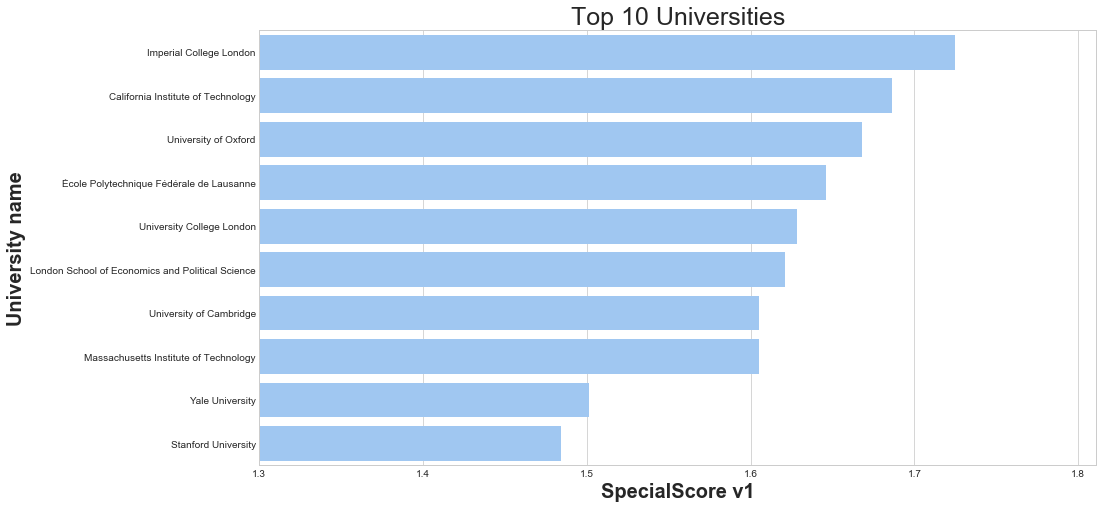

In [947]:
plt.figure(figsize=(15,8))
#pal = seaborn.color_palette("Greens_d", 10)
#rank = final.SpecialScore
ax = seaborn.barplot(y="title_QS", x="SpecialScore", data=ranking_1, color='b')
ax.axes.set_xlim(left=1.3)
ax.set_xlabel('SpecialScore v1', fontsize=20).set_weight('bold')
ax.set_ylabel('University name', fontsize=20).set_weight('bold')
plt.title("Top 10 Universities", fontsize=25)

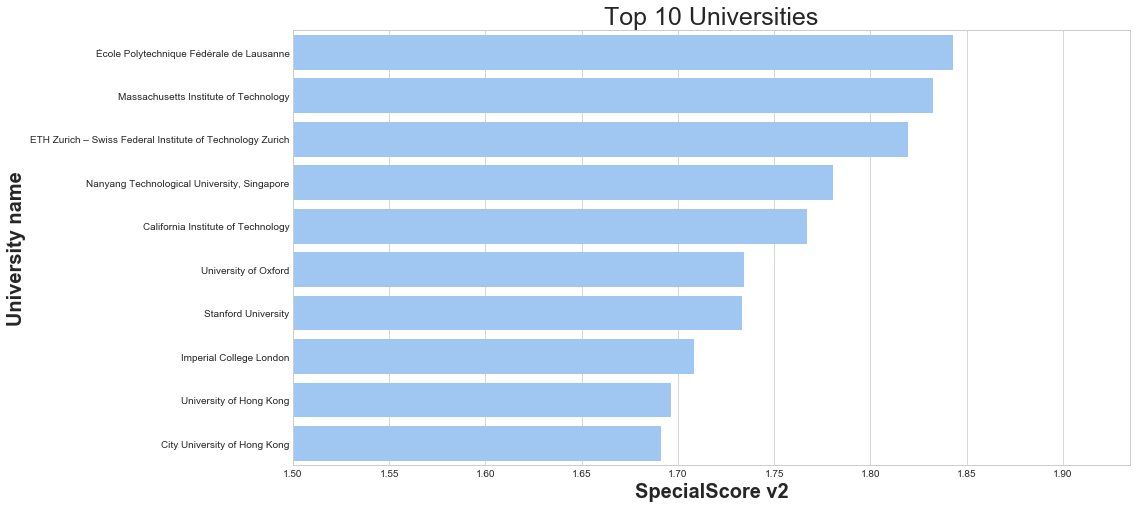

In [953]:
plt.figure(figsize=(15,8))

ax = seaborn.barplot(y="title_QS", x="SpecialScore", data=ranking_2, color='b')
ax.axes.set_xlim(left=1.5)
ax.set_xlabel('SpecialScore v2', fontsize=20).set_weight('bold')
ax.set_ylabel('University name', fontsize=20).set_weight('bold')
plt.title("Top 10 Universities", fontsize=25)

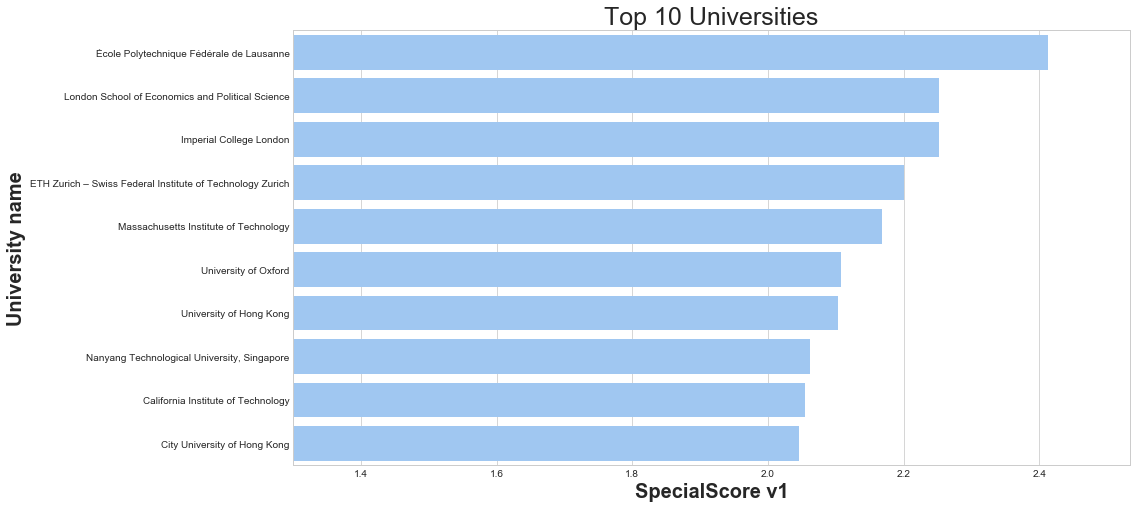

In [954]:
new_score_3 = 1/(mergednotnull['Students:Staff Ratio_x']) + mergednotnull['score']/100 \
               + mergednotnull['number of international faculty members']/mergednotnull['number of faculty members'] \
                + mergednotnull['Students international:Students Ratio_x']

mergednotnull['SpecialScore'] = new_score_3
ranking_3 = mergednotnull.sort_values('SpecialScore', ascending=False).head(10)

plt.figure(figsize=(15,8))
ax = seaborn.barplot(y="title_QS", x="SpecialScore", data=ranking_3, color='b')
ax.axes.set_xlim(left=1.3)
ax.set_xlabel('SpecialScore v1', fontsize=20).set_weight('bold')
ax.set_ylabel('University name', fontsize=20).set_weight('bold')
plt.title("Top 10 Universities", fontsize=25)